# IE613-Birr final land survey

The first order of business is to read the CSV file containing the ETRS89 measurements of the surface of the Birr station.

In [141]:
from numpy import *
from matplotlib.pyplot import *
from numpy.linalg.linalg import norm
%matplotlib inline
import csv, re
def s(arr):
    '''Shorthand for printing array (with round brackets)'''
    return array2string(arr,
                        separator=",",
                        precision=3.7).replace("[ ","(").replace("]",")")

In [142]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [143]:
with open('Flattening Converted Rev 1.csv', 'r') as csv_file:
    ecef_rows = [(row[0],
                 array([float(num) for num in row[1:4]]),
                 row[7]
                )
                for row in csv.reader(csv_file, delimiter=';')
                if 'Point-ID' not in row[0]]
print(len(ecef_rows))
ecef_rows[0:3]

563


[('P001', array([ 3801681.706,  -528956.856,  5076968.549]), 'HBA'),
 ('P002', array([ 3801682.73 ,  -528959.471,  5076967.442]), 'HBA'),
 ('P003', array([ 3801683.796,  -528962.121,  5076966.369]), 'HBA')]

### Survey coordinates statistics

In [144]:
import lofargeo

The variable `position_dict` can be used to look up positions based on the name of the point. *spotlevels_etrs* is an array of all 3D ETRS coordinates, and *all_names* holds the corresponding names.

For determining the reference plane, we only use spot levels.

In [145]:
position_dict = dict([row[0:2] for row in ecef_rows])
levels_etrs={}
levels_etrs['LBA'] = array([row[1] for row in ecef_rows if row[2]=='LBA'])
levels_etrs['HBA'] = array([row[1] for row in ecef_rows if row[2]=='HBA'])
levels_etrs['all'] = array([row[1] for row in ecef_rows])
all_names = [row[0] for row in ecef_rows]
mean_position = levels_etrs['all'].mean(axis=0)
print('Mean position LBA (ETRS89): ', mean_position)

Mean position LBA (ETRS89):  [ 3801673.26296448  -528996.43081705  5076970.442627  ]


And in geographic coordinates in radians and meters:

In [146]:
geo_mean = lofargeo.geographic_from_xyz(mean_position)

print('''LBA:
lat_rad : %(lat_rad).10f rad
lon_rad : %(lon_rad).10f rad
height_m: %(height_m).3f m)''' % geo_mean)

LBA:
lat_rad : 0.9266804812 rad
lon_rad : -0.1382605317 rad
height_m: 99.257 m)


The normal vector to the WGS84 ellipsoid is then

In [147]:
ellipsoid_normal = lofargeo.normal_vector_ellipsoid(geo_mean['lon_rad'], geo_mean['lat_rad'])
print("Normal to WGS84 ellipsoid:", ellipsoid_normal)

Normal to WGS84 ellipsoid: [ 0.59476132 -0.08276004  0.79963101]


For plotting purposes, we also read in the array base coordinates from the initial site survey.

In [148]:
arraybase_etrs = np.load("arraybase_etrs.npy")

## Best fit plane and deviations from that plane

In [149]:
solution={}
solution['LBA'] = lofargeo.fit_plane(levels_etrs['LBA'])
solution['HBA'] = lofargeo.fit_plane(levels_etrs['HBA'])
matrix_pqr_to_etrs={}
matrix_pqr_to_etrs['LBA'] = lofargeo.projection_matrix(lofargeo.LOFAR_XYZ0_m, solution['LBA']['normal'])
matrix_pqr_to_etrs['HBA'] = lofargeo.projection_matrix(lofargeo.LOFAR_XYZ0_m, solution['HBA']['normal'])
print('Normal vector LBA:', solution['LBA']['normal'])
print('Mean position LBA:', solution['LBA']['mean'])
print('Rotation matrix PQR to ETRS LBA:\n', matrix_pqr_to_etrs['LBA'])
print('Normal vector HBA:', solution['HBA']['normal'])
print('Mean position HBA:', solution['HBA']['mean'])
print('Rotation matrix PQR to ETRS HBA:\n', matrix_pqr_to_etrs['HBA'])

Normal vector LBA: [ 0.59625686 -0.08562493  0.79821434]
Mean position LBA: [ 3801633.34248901  -529021.85204396  5076997.32945605]
Rotation matrix PQR to ETRS LBA:
 [[-0.02673324 -0.80234848  0.59625686]
 [ 0.99162649 -0.09667101 -0.08562493]
 [ 0.12634178  0.58897506  0.79821434]]
Normal vector HBA: [ 0.59596131 -0.08744378  0.79823787]
Mean position HBA: [ 3801692.33258793  -528984.28734383  5076957.59904987]
Rotation matrix PQR to ETRS HBA:
 [[-0.0257191  -0.80260117  0.59596131]
 [ 0.99146478 -0.09670145 -0.08744378]
 [ 0.12781281  0.58862568  0.79823787]]


In [150]:
matrix_pqr_to_etrs['HBA']

array([[-0.0257191 , -0.80260117,  0.59596131],
       [ 0.99146478, -0.09670145, -0.08744378],
       [ 0.12781281,  0.58862568,  0.79823787]])

In [151]:
angle_lba_hba=rad2deg(arccos(dot(solution['HBA']['normal'],solution['LBA']['normal'])))

In [152]:
print("Angle between LBA normal and HBA normal:",angle_lba_hba,"degrees")

Angle between LBA normal and HBA normal: 0.105588317015 degrees


In [153]:
print("Over 150m, this can lead to height differences of", tan(deg2rad(angle_lba_hba))*150, "m")

Over 150m, this can lead to height differences of 0.276429880464 m


### CLBA and CHBA from initial site survey

Read the CLBA and CHBA centers from the initial site survey.

In [154]:
clba_etrs_given=np.load("centers.npz")['clba_etrs_given']
chba_etrs_given=np.load("centers.npz")['chba_etrs_given']

In [155]:
[clba_pqr] = lofargeo.transform(array([clba_etrs_given,]),
                              solution['LBA']['mean'],
                              matrix_pqr_to_etrs['LBA'].T)
[chba_pqr] = lofargeo.transform(array([chba_etrs_given,]),
                              solution['HBA']['mean'],
                              matrix_pqr_to_etrs['HBA'].T)

Force the centers to be in the plane in the plane (set *r*-component to 0).

In [156]:
clba_pqr[2]=0
chba_pqr[2]=0
clba_etrs = dot(matrix_pqr_to_etrs['LBA'], clba_pqr) + solution['LBA']['mean']
chba_etrs = dot(matrix_pqr_to_etrs['HBA'], chba_pqr) + solution['HBA']['mean']

The LBA center and HBA center are put in the plane of the station. The measurement for the centers shows larger elevations than the spot level points, which explains the large difference with non-projected centers. This difference is in the r-direction.

In [157]:
print("Distance between measured CLBA and projected CLBA (meters):",
      norm(clba_etrs_given - clba_etrs))
print("Distance between measured CHBA and projected CHBA (meters):",
      norm(chba_etrs_given - chba_etrs))

Distance between measured CLBA and projected CLBA (meters): 0.290469605211
Distance between measured CHBA and projected CHBA (meters): 0.426663762487


Since the LBA and HBA centers are now in the plane of the station, we can use them as the new origins.

In [158]:
clba_pqr=array([0.,0.,0.]);
chba_pqr=array([0.,0.,0.]);

To transform a point `a` from LBA-pqr to ETRS, use:

In [159]:
a_pqr = [42,0,0]; # Example: 42 meter right of the LBA center
a_etrs = lofargeo.transform(array([a_pqr]),
                   [0,0,0],
                   matrix_pqr_to_etrs['LBA']) + clba_etrs

In [160]:
norm(a_pqr-clba_pqr)

42.0

In [161]:
norm(a_etrs-clba_etrs)

41.999999999966164

## Convert all survey points, plot

In [162]:
from matplotlib.path import Path
import matplotlib.patches

### LBA

In [163]:
station_pqr={}
station_pqr['LBA'] = lofargeo.transform(levels_etrs['LBA'],
                                        clba_etrs,
                                        matrix_pqr_to_etrs['LBA'].T)
station_height_deviation_fn = lofargeo.interpolation_function(station_pqr['LBA'])
print('p range: ', station_pqr['LBA'][:,0].min(),'–', station_pqr['LBA'][:,0].max())
print('q range: ', station_pqr['LBA'][:,1].min(),'–', station_pqr['LBA'][:,1].max())

p range:  -35.823367207 – 35.7077120835
q range:  -33.4803725988 – 35.8965822598


In [164]:
[pmin,pmax,qmin,qmax] = [-50, 60, -40, 50]
p_m, q_m = meshgrid(arange(pmin, pmax), arange(qmin, qmax))
r_m = station_height_deviation_fn(p_m, q_m)

Convert the array base to the pqr system, to mask points outside the array base.

In [165]:
arraybase_pqr = lofargeo.transform(arraybase_etrs,
                                   clba_etrs,
                                   matrix_pqr_to_etrs['LBA'].T)

CLBA_PQR: [ 0.  0.  0.]
CHBA_PQR: [ 0.  0.  0.]


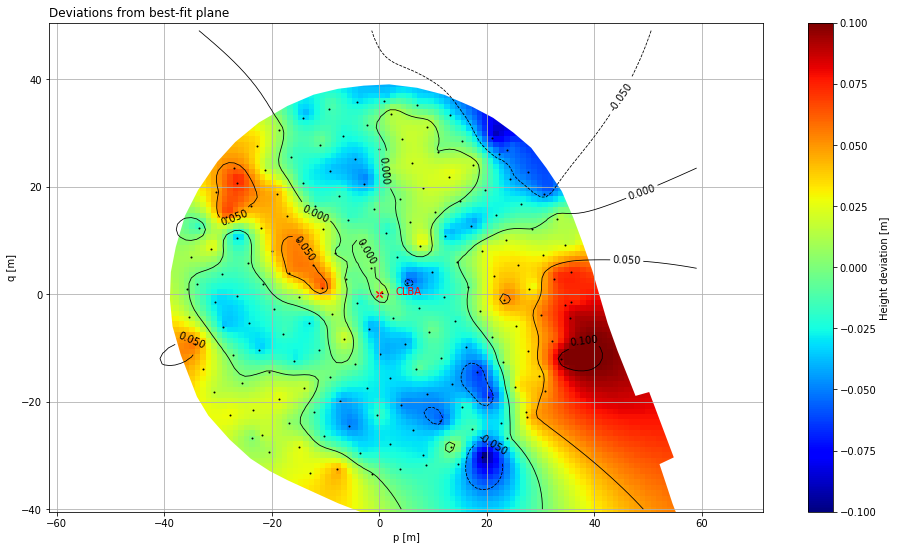

In [166]:
arraybase_path_pqr = Path(append(arraybase_pqr[:,0:2],
                     array([[200,0],[200,100],[-120,100],[-120,-150],
                            [200,-150],[200,0],arraybase_pqr[-1,0:2]]),
                     axis=0))
maskpatch = matplotlib.patches.PathPatch(arraybase_path_pqr, facecolor='white',
                                         edgecolor='white', lw=2, zorder=1)

figure(figsize=(16, 9))
imshow(r_m, origin='lower', extent=(pmin-0.5, pmax+0.5, qmin-0.5, qmax+0.5),
       vmin=-.1, vmax=+.1, cmap='jet')
axis('equal')
xlim([pmin,pmax])
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, levels=arange(-1.0, +1.0, 0.05), colors='black', linewidths=.8)
cnt.clabel(inline=True)
xlabel('p [m]')
ylabel('q [m]')
scatter(station_pqr['LBA'][:,0], station_pqr['LBA'][:,1], s=1, color='black')

title('''Deviations from best-fit plane''', loc='left')
#title('''Deviations from best-fit plane
#Origin ETRS: %s\nNormal: %s
#CHBA_ETRS = (%.3f, %.3f, %.3f)
#CLBA_ETRS = (%.3f, %.3f, %.3f)''' %
#      (s(solution['mean']), s(solution['normal']),
#       chba_etrs[0], chba_etrs[1], chba_etrs[2],
#       clba_etrs[0], clba_etrs[1], clba_etrs[2]), loc='left')

scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
text(clba_pqr[0]+3, clba_pqr[1], 'CLBA', color='red')

gca().add_patch(maskpatch)

savefig("deviation.pdf")
print("CLBA_PQR:", clba_pqr)
print("CHBA_PQR:", chba_pqr)
savefig("deviations-LBA.pdf")

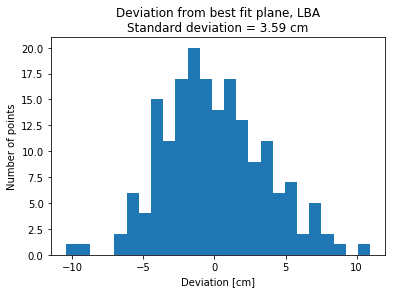

In [167]:
hist(station_pqr['LBA'][:,2]*100, bins=25)
title("Deviation from best fit plane, LBA\nStandard deviation = %4.2f cm"%(100*station_pqr['LBA'][:,2].std()));
xlabel("Deviation [cm]");
ylabel("Number of points");

### HBA

In [168]:
station_pqr['HBA'] = lofargeo.transform(levels_etrs['HBA'],
                                        chba_etrs,
                                        matrix_pqr_to_etrs['HBA'].T)
station_height_deviation_fn = lofargeo.interpolation_function(station_pqr['HBA'])
print('p range: ', station_pqr['HBA'][:,0].min(),'–', station_pqr['HBA'][:,0].max())
print('q range: ', station_pqr['HBA'][:,1].min(),'–', station_pqr['HBA'][:,1].max())

p range:  -31.3592839759 – 31.4415862967
q range:  -31.3759203754 – 31.2451732162


In [169]:
[pmin,pmax,qmin,qmax] = [-50, 60, -40, 40]
p_m, q_m = meshgrid(arange(pmin, pmax), arange(qmin, qmax))
r_m = station_height_deviation_fn(p_m, q_m)

Convert the array base to the pqr system, to mask points outside the array base.

In [170]:
arraybase_pqr = lofargeo.transform(arraybase_etrs,
                                   chba_etrs,
                                   matrix_pqr_to_etrs['HBA'].T)

/anaconda/envs/school2017/lib/python3.6/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


CLBA_PQR: [ 0.  0.  0.]
CHBA_PQR: [ 0.  0.  0.]


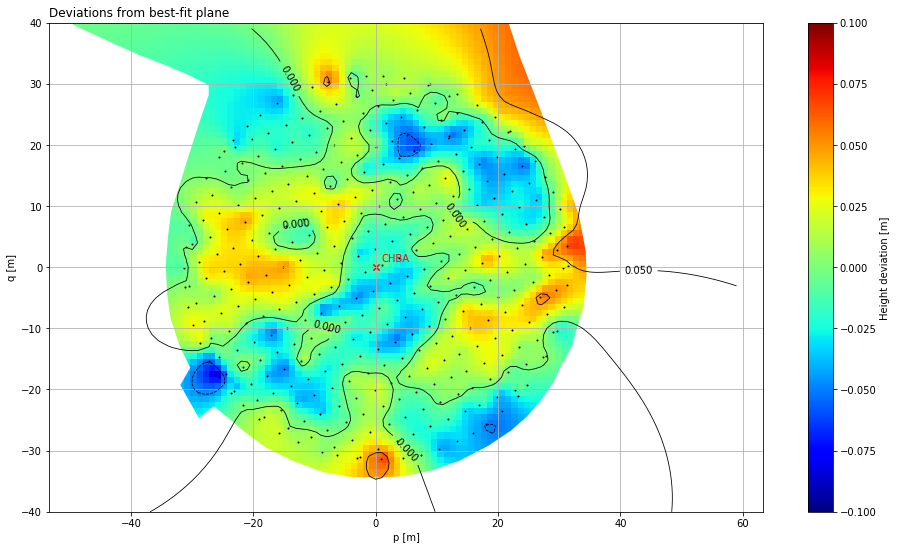

In [171]:
arraybase_path_pqr = Path(append(arraybase_pqr[:,0:2],
                     array([[200,0],[200,100],[-120,100],[-120,-150],
                            [200,-150],[200,0],arraybase_pqr[-1,0:2]]),
                     axis=0))
maskpatch = matplotlib.patches.PathPatch(arraybase_path_pqr, facecolor='white',
                                         edgecolor='white', lw=2, zorder=1)

figure(figsize=(16, 9))
imshow(r_m, origin='lower', extent=(pmin-.5, pmax+0.5, qmin, qmax),
       vmin=-.1, vmax=+.1, cmap='jet')
axis('equal')
xlim([pmin,pmax])
grid()
cb = colorbar()
cb.set_label('Height deviation [m]')
cnt = contour(p_m, q_m, r_m, levels=arange(-1.0, +1.0, 0.05), colors='black', linewidths=.8)
cnt.clabel(inline=True)
xlabel('p [m]')
ylabel('q [m]')
scatter(station_pqr['HBA'][:,0], station_pqr['HBA'][:,1], s=1, color='black')

title('''Deviations from best-fit plane''', loc='left')
#title('''Deviations from best-fit plane
#Origin ETRS: %s\nNormal: %s
#CHBA_ETRS = (%.3f, %.3f, %.3f)
#CLBA_ETRS = (%.3f, %.3f, %.3f)''' %
#      (s(solution['mean']), s(solution['normal']),
#       chba_etrs[0], chba_etrs[1], chba_etrs[2],
#       clba_etrs[0], clba_etrs[1], clba_etrs[2]), loc='left')

scatter(0, 0, color='red', s=40, marker='x')
text(1, 1, 'CHBA', color='red')

gca().add_patch(maskpatch)

savefig("deviation.pdf")
print("CLBA_PQR:", clba_pqr)
print("CHBA_PQR:", chba_pqr)
savefig("deviations-HBA.pdf")

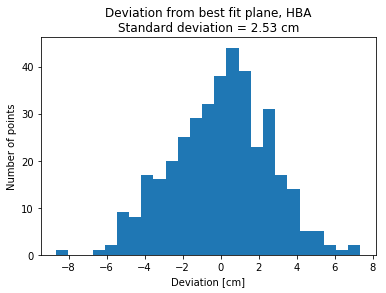

In [172]:
hist(station_pqr['HBA'][:,2]*100, bins=25)
title("Deviation from best fit plane, HBA\nStandard deviation = %4.2f cm"%(100*station_pqr['HBA'][:,2].std()));
xlabel("Deviation [cm]");
ylabel("Number of points");

## Station rotation

The rotation of this station (in the pqr-system) has been decided to be 84 degrees.

## Read in PQ Coordinates IE-613 LBA HBA Container V1

In [173]:
with open('PQ Coordinates IE-613 LBA HBA Container V1.csv', 'r') as csv_file:
    pqr_v1 = {}
    reader = csv.reader(csv_file, delimiter=';')
    next(reader) # Skip header
    for row in csv.reader(csv_file, delimiter=';'):
        pqr_v1[row[0]]=array([float(num) for num in row[1:]])
print(len(pqr_v1))

698


In [174]:
def getmarkertype(markerlabel):
    ''' Return the marker type depending on the point label'''
    if markerlabel[0:2]=='11': return "LBA Cable exit marker"
    if markerlabel[0:2]=='12': return "LBA Marker 2 ('piketten boven')"
    if markerlabel[0:2]=='13': return "LBA Marker 3 ('piketten beneden')"
    if markerlabel[0:3]=='LBD': return "Hulppiketten graven LBA veld"

    if markerlabel[0:2]=='20': return "HBA Cable entrance points"
    if markerlabel[0:2]=='21' or markerlabel[0:2]=='22': return "HBA Marker points"
    if markerlabel[0:3]=='HBD': return "Hulppiketten graven HBA veld"
    
    if markerlabel[0]=='C': return "Container"

    raise Exception("Unknown markerlabel", markerlabel)

Convert all piket-coordinates to ETRS with the corresponding solution (LBA or HBA).

In [175]:
pqr_v1_etrs = {}
numlba = 0; numhba = 0;
for markerlabel in pqr_v1:
    markertype = getmarkertype(markerlabel)
    if 'LBA' in markertype or 'Container' in markertype:
        field = 'LBA'
        fieldcenter_etrs = clba_etrs
        numlba+=1
    elif 'HBA' in markertype:
        field = 'HBA'
        fieldcenter_etrs = chba_etrs
        numhba+=1
    pqr_v1_etrs[markerlabel] = lofargeo.transform(array([pqr_v1[markerlabel]]), 
                                                  [0,0,0], 
                                                  matrix_pqr_to_etrs[field]) + fieldcenter_etrs

sum([len(lst[1]) for lst in pqr_v1_etrs.items()])    

698

Export the ETRS coordinates

In [176]:
tmppt=pqr_v1_etrs['1100']

In [177]:
tmppt=lofargeo.geographic_from_xyz(tmppt[0])

In [178]:
with open('coordinates_v1_etrs.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=';', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["Label", "ETRS-X", "ETRS-Y", "ETRS-Z", "ETRS-lat", "ETRS-long", "Type"])
    for markerlabel in pqr_v1_etrs:
        pt_etrs=pqr_v1_etrs[markerlabel][0]
        pt_ll=lofargeo.geographic_from_xyz(pt_etrs)
        row=[markerlabel]
        row+=list(pt_etrs)
        row+=[rad2deg(pt_ll['lat_rad']), rad2deg(pt_ll['lon_rad'])]
        row+=[getmarkertype(markerlabel)]
        csvwriter.writerow(row)

### Cable grave location

Cable grave PQR positions from Eim:

In [179]:
with open('cablegravepositions.csv', 'r') as csv_file:
    cablegrave_pqr = {}
    reader = csv.reader(csv_file, delimiter=';')
    for row in csv.reader(csv_file, delimiter=';'):
        cablegrave_pqr[row[0]]=array([float(num) for num in row[1:]])
print(len(cablegrave_pqr))

12


Use LBA solutions for the cable grave:

In [180]:
with open('cablegrave_etrs.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=';', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["Label", "ETRS-X", "ETRS-Y", "ETRS-Z", "ETRS-lat", "ETRS-long", "Type"])
    for label in cablegrave_pqr:
        pt_etrs = (lofargeo.transform(array([cablegrave_pqr[label]]), 
                                                  [0,0,0], 
                                                  matrix_pqr_to_etrs['LBA']) + clba_etrs)[0]
        pt_ll=lofargeo.geographic_from_xyz(pt_etrs)
        row=[label]
        row+=list(pt_etrs)
        row+=[rad2deg(pt_ll['lat_rad']), rad2deg(pt_ll['lon_rad'])]
        row+=["Cable grave marker"]
        csvwriter.writerow(row)

### Plot markers

In [181]:
pqr_v1_bytype=dict();
pqr_v1_bytype["LBA Cable exit marker"]=array([pqr_v1[k] for k in pqr_v1 if k[0:2]=='11']);
pqr_v1_bytype["LBA Marker 2 ('piketten boven')"]=array([pqr_v1[k] for k in pqr_v1 if k[0:2]=='12']);
pqr_v1_bytype["LBA Marker 3 ('piketten beneden')"]=array([pqr_v1[k] for k in pqr_v1 if k[0:2]=='13']);
pqr_v1_bytype["Hulppiketten graven LBA veld"]=array([pqr_v1[k] for k in pqr_v1 if k[0:3]=='LBD']);

# PQR coordinates for HBA are given relative to HBA center, leave that as it is
pqr_v1_bytype["HBA Cable entrance points"] = array([pqr_v1[k] for k in pqr_v1 if k[0:2]=='20']);
pqr_v1_bytype["HBA Marker points"] = array([pqr_v1[k] for k in pqr_v1 if k[0:2]=='21' or k[0:2]=='22']);
pqr_v1_bytype["Hulppiketten graven HBA veld"] = array([pqr_v1[k] for k in pqr_v1 if k[0:3]=='HBD']);

pqr_v1_bytype["Container"]=array([pqr_v1[k] for k in pqr_v1 if k[0]=='C']);

sum([len(lst[1]) for lst in pqr_v1_bytype.items()])

698

In [182]:
# Reorder container points so that contours are drawn:
containerpts = pqr_v1_bytype["Container"][[1,2,4,3,1],:]

In [183]:
colors=dict();
colors["LBA Cable exit marker"] = "red";
colors["HBA Cable entrance points"] = "blue";
colors["Hulppiketten graven HBA veld"] = "orange";
colors["Hulppiketten graven LBA veld"] = "orange";
colors["LBA Marker 2 ('piketten boven')"] = "green";
colors["LBA Marker 3 ('piketten beneden')"] = "green";
colors["HBA Marker points"] = "green";

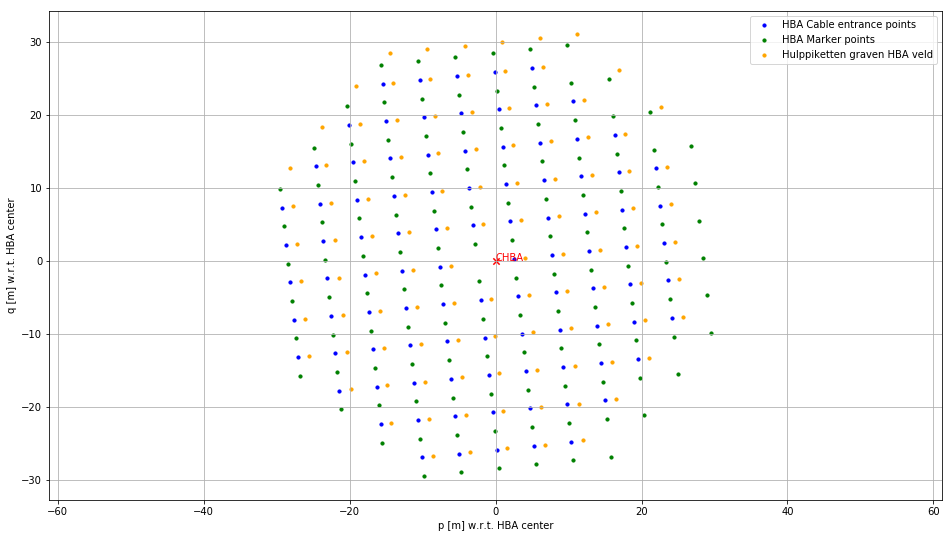

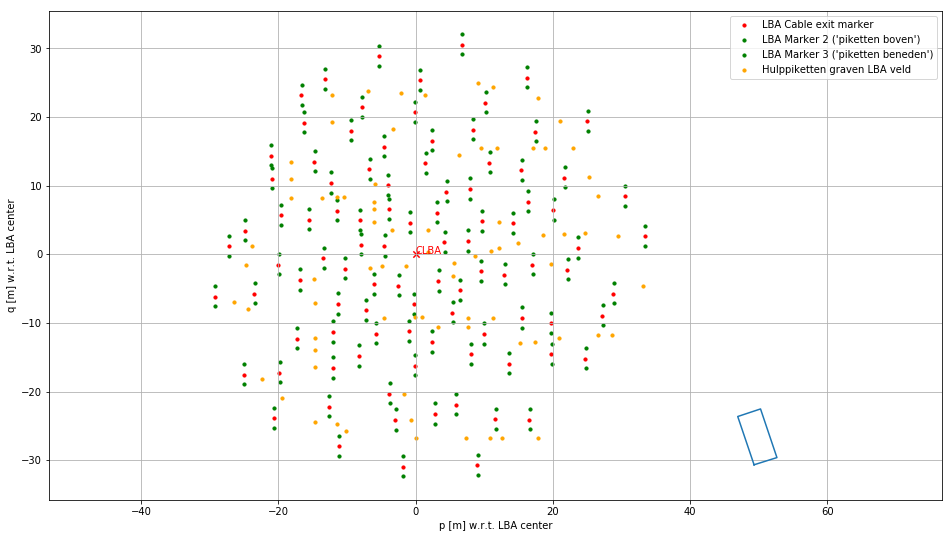

In [184]:
for field in ['HBA', 'LBA']:
    arraybase_path_pqr = Path(append(arraybase_pqr[:,0:2],
                         array([[200,0],[200,100],[-120,100],[-120,-150],
                                [200,-150],[200,0],arraybase_pqr[-1,0:2]]),
                         axis=0))
    maskpatch = matplotlib.patches.PathPatch(arraybase_path_pqr, facecolor='white',
                                             edgecolor='white', lw=2, zorder=1)

    figure(figsize=(16, 9))

    axis('equal')
    grid()

    xlabel('p [m] w.r.t. '+field+' center')
    ylabel('q [m] w.r.t. '+field+' center')

    for markertype in pqr_v1_bytype:
        if markertype == "Container":
            continue
        else:
            if field in markertype:
                scatter(pqr_v1_bytype[markertype][:,0], pqr_v1_bytype[markertype][:,1],
                        s=10, color=colors[markertype], label=markertype)

    if field=="LBA":
        plot(containerpts[:,0], containerpts[:,1])        

    legend()

    if field=="HBA":
        scatter(chba_pqr[0], chba_pqr[1], color='red', s=40, marker='x')
        text(chba_pqr[0], chba_pqr[1], 'CHBA', color='red')

    if field=="LBA":
        scatter(clba_pqr[0], clba_pqr[1], color='red', s=40, marker='x')
        text(clba_pqr[0], clba_pqr[1], 'CLBA', color='red')

    gca().add_patch(maskpatch);

    savefig("markers_v1-"+field+".pdf")

## Export to csv format required by LOFAR software

Import the wiring (RCU connections). This was copied from `pl612-antenna-positions-etrs.ods`:

In [185]:
rcus = dict()
with open('wiring.csv', 'r') as csvfile:
    for row in csv.reader(csvfile, delimiter=','):
        if 'NAME' in row[0]:
            continue # Skip header
        rcus[row[0]] = (int(row[1]), int(row[2]))

The coordinates for the **LBA** antennas correspond to the cable exit marker, which in Eim's spreadsheet are labeled `1100` to `1195`.

In [186]:
with open('ie613-antenna-positions-etrs.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["NAME","ETRS-X","ETRS-Y","ETRS-Z","STATION-P","STATION-Q","STATION-R","RCU-X","RCU-Y"])
    for label in [label for label in pqr_v1 if label[0:2]=='11']:
        lbanum = 'L'+str(int(label[2:]))
        row = [lbanum]
        row += list(pqr_v1_etrs[label][0])
        row += list(pqr_v1[label])
        row += rcus[lbanum]
        csvwriter.writerow(row)

For **HBA**, the antenna positions (tile center) need to be computed from the cable exit marker: they are 2.575 m 'upwards' from the cable exit marker in the pqr-system. Here, 'upwards' means in the direction of tile rotation. E.g. for an exit marker at *(0,0)*, the antenna position is at *(0,0) + 2.575 (cos(phi), sin(phi))*, where phi is the HBA rotation.

The coordinates for the HBA cable exit markers in Eim's spreadsheet are labeled `2000` to `2095`.

In [187]:
tilecenters_pqr = dict()
for label in [label for label in pqr_v1 if label[0:2]=='20']:
    tilecenters_pqr[label] = pqr_v1[label] + 2.575*np.array((sin(np.deg2rad(84)), cos(np.deg2rad(84)), 0))

In [188]:
tilecenters_pqr['2000']

array([ 24.53189388,  12.93516079,   0.        ])

In [189]:
pqr_v1['2000']

array([ 21.971,  12.666,   0.   ])

We need to convert these to ETRS again:

In [190]:
tilecenters_etrs = dict()
for label in tilecenters_pqr:
    tilecenters_etrs[label] = (lofargeo.transform(array([tilecenters_pqr[label]]), 
                                                 [0,0,0], 
                                                 matrix_pqr_to_etrs['HBA']) + chba_etrs)[0]

Write the ETRS tile centers as lat-long to a temporary csv to plot them:

In [191]:
with open('ie613-tilecenters_etrs_ll.csv', 'w') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["Label","Lat","Long"])
    for label, etrspos in tilecenters_etrs.items():
        etrspos_ll = lofargeo.geographic_from_xyz(etrspos)
        csvwriter.writerow([label, rad2deg(etrspos_ll['lat_rad']), rad2deg(etrspos_ll['lon_rad'])])

Now export to CSV:

In [192]:
with open('ie613-antenna-positions-etrs.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    for label in [label for label in pqr_v1 if label[0:2]=='20']:
        hbanum = 'H'+str(int(label[2:]))
        row = [hbanum]
        row += list(tilecenters_etrs[label])        
        row += list(tilecenters_pqr[label])
        row += rcus[hbanum]
        csvwriter.writerow(row)        

Now add LBA center and HBA center:

In [193]:
clba_pqr

array([ 0.,  0.,  0.])

In [194]:
with open('ie613-antenna-positions-etrs.csv', 'a') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    csvwriter.writerow(["CLBA"] + list(clba_etrs) + list(clba_pqr) + [-1,-1])
    csvwriter.writerow(["CHBA"] + list(chba_etrs) + list(chba_pqr) + [-1,-1])

## Export best fit plane solution to LISP-format

In [195]:
def array2lisp(a):
    out = str(a)
    out = out.replace("[", "(")
    out = out.replace("]", ")")
    return out

In [196]:
for field in ('LBA', 'HBA'):
    with open("ie613-{}-solution.lisp".format(field.lower()), "w") as f:
        print("(normal-vector ", end='', file=f)
        print(array2lisp(solution['LBA']['normal']) + ")", file=f)
        print("(reference-point :etrs ", end='', file=f)
        print(array2lisp(clba_etrs), file=f)
        print("                 :station-pqr ", end='', file=f)
        print(array2lisp(clba_pqr) + ")", file=f)
        print("(station-pqr-to-etrs-matrix", file=f)
        print("#2A", end='', file=f)
        print(array2lisp(matrix_pqr_to_etrs['LBA']) + ")", file=f)